## Import des librairies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras import metrics as m
from numpy import zeros
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.python.keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional, GlobalMaxPool2D, SpatialDropout1D, concatenate, Conv1D
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
%matplotlib inline
import gensim.models.keyedvectors as word2vec
import gc
import joblib
import pickle

Using TensorFlow backend.


# Import des données

In [ ]:
# Dataset labellisé "train" disponible sur Kaggle
train = pd.read_csv('/content/drive/My Drive/Projet_fil_rouge/data/train.csv')
# Dataset non labellisé "test" disponible sur Kaggle
test = pd.read_csv('/content/drive/My Drive/Projet_fil_rouge/data/test.csv')

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

# Nettoyage des données

In [ ]:
def clean_one_comment(comment):
    """
    Clean a sentence (string) by converting it into lower case, removing or replacing unwanted expressions 
    and removing characters from both left and right.
    Arguments:
    comment -- string, one training example from X
    Returns:
    cleaned_comment -- cleaned string
    """
    # Step 1: Transform the string into lower case words
    comment_lower = comment.lower()
    # Step 2: Remove or replace the unwanted expressions (more could be added)
    comment_inter = re.sub(r"i'm", "i am ", comment_lower)
    comment_inter = re.sub(r"what's", "what is ", comment_inter)
    comment_inter = re.sub(r"\'ve", " have ", comment_inter)
    comment_inter = re.sub(r"\'s", " ", comment_inter)
    comment_inter = re.sub(r"can't", "can not ", comment_inter)
    comment_inter = re.sub(r"n't", " not ", comment_inter)
    comment_inter = re.sub(r"\'re", " are ", comment_inter)
    comment_inter = re.sub(r"\'d", " would ", comment_inter)
    comment_inter = re.sub(r"\'ll", " will ", comment_inter)
    comment_inter = re.sub(r"\'scuse", " excuse ", comment_inter)
    comment_inter = re.sub('\W', ' ', comment_inter)
    comment_inter = re.sub('\s+', ' ', comment_inter)
    # ...
    # Step 3: Remove characters from both left and right 
    cleaned_comment = comment_inter.strip()
    # Remove punctuations and numbers
    cleaned_comment = re.sub('[^a-zA-Z]', ' ', cleaned_comment)
    # Single character removal
    cleaned_comment = re.sub(r"\s+[a-zA-Z]\s+", ' ', cleaned_comment)
    return cleaned_comment

In [ ]:
# Nettoyage des données du dataset de train et de test
list_sentences_train = list_sentences_train.apply(lambda x : clean_one_comment(x))
list_sentences_test = list_sentences_test.apply(lambda x : clean_one_comment(x))

# Construction et évaluation des modèles

Dans cette partie, on construit puis on évalue deux architectures de réseaux de neurones : un LSTM bidirectionnel et un CNN Conv1D.

## Split Train / Validation à partir du jeu labellisé "train"

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(list_sentences_train,y,test_size=0.3,random_state=0)

In [ ]:
X_train.shape, X_valid.shape

((111699,), (47872,))

### Tokenisation

In [ ]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(list(X_train))
list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_valid = tokenizer.texts_to_sequences(X_valid)
word_index = tokenizer.word_index

In [ ]:
#sauvegarde modèle tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl') 

['tokenizer.pkl']

In [ ]:
maxlen = 150
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_v = pad_sequences(list_tokenized_valid, maxlen=maxlen)

## Préparation de l'embedding

In [ ]:
embeddings_dictionary_glove = dict()

path = '/content/drive/My Drive/Projet Kaggle/Scripts/GLOVE/glove.6B.300d.txt'
glove_file = open(path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary_glove[word] = vector_dimensions
glove_file.close()

embedding_matrix_glove = zeros((len(tokenizer.word_index)+1, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[index] = embedding_vector

## Construction et évaluation du 1er modèle : LSTM bidirectionnel

In [ ]:
inp = Input(shape=(maxlen, )) 
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix_glove.shape[1],weights=[embedding_matrix_glove],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inp, x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[m.AUC()])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 300)          41283300  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 150, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 256)          439296    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0   

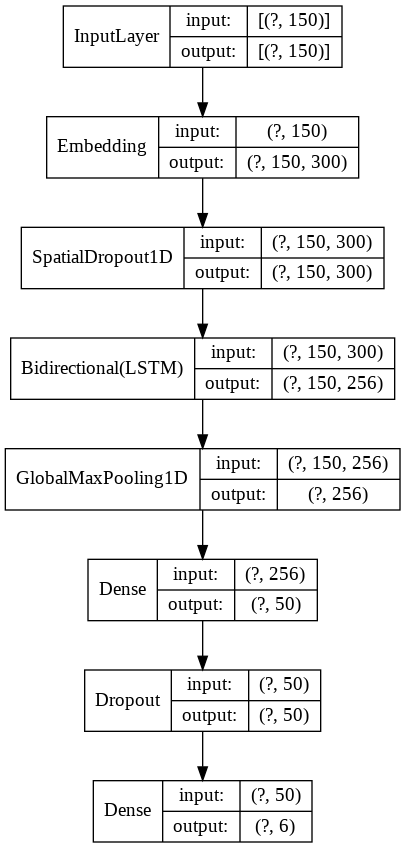

In [ ]:
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/Projet_fil_rouge/model_plot_lstm.png', 
                          show_shapes=True, show_layer_names=False)#, rankdir='LR')

In [ ]:
#entrainement du modèle 
batch_size = 128
epochs = 10
model.fit(X_t,Y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(X_v, Y_valid),
          callbacks=EarlyStopping(monitor='val_loss'))

Epoch 1/10
873/873 [==============================] - 854s 978ms/step - loss: 0.0735 - auc_3: 0.8868 - val_loss: 0.0508 - val_auc_3: 0.9599
Epoch 2/10
873/873 [==============================] - 856s 980ms/step - loss: 0.0512 - auc_3: 0.9674 - val_loss: 0.0464 - val_auc_3: 0.9716
Epoch 3/10
873/873 [==============================] - 875s 1s/step - loss: 0.0466 - auc_3: 0.9742 - val_loss: 0.0459 - val_auc_3: 0.9760
Epoch 4/10
873/873 [==============================] - 851s 975ms/step - loss: 0.0436 - auc_3: 0.9774 - val_loss: 0.0440 - val_auc_3: 0.9785
Epoch 5/10
873/873 [==============================] - 845s 968ms/step - loss: 0.0410 - auc_3: 0.9795 - val_loss: 0.0440 - val_auc_3: 0.9803


In [ ]:
print("Score ROC AUC pour le modèle : %0.3f" %model.evaluate(X_v, Y_valid)[1])

1496/1496 [==============================] - 168s 113ms/step - loss: 0.0440 - auc_3: 0.9804
Score ROC AUC pour le modèle : 0.980


## Construction et évaluation du 2nd modèle : CNN (Conv1D)

In [ ]:
inp = Input(shape=(maxlen, )) 
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix_glove.shape[1],weights=[embedding_matrix_glove],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inp, x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[m.AUC()])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 300)          41283300  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 150, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 146, 128)          192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0   

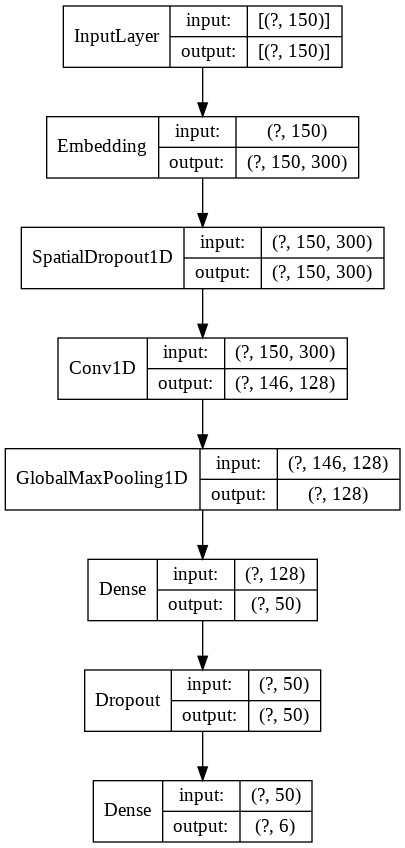

In [ ]:
tf.keras.utils.plot_model(model, to_file='/content/drive/My Drive/Projet_fil_rouge/model_plot_cnn.png', 
                          show_shapes=True, show_layer_names=False)#, rankdir='LR')

In [ ]:
#entrainement du modèle 
batch_size = 128
epochs = 10
model.fit(X_t,Y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_data=(X_v, Y_valid),
          callbacks=EarlyStopping(monitor='val_loss'))

Epoch 1/10
873/873 [==============================] - 43s 50ms/step - loss: 0.0778 - auc_2: 0.8844 - val_loss: 0.0532 - val_auc_2: 0.9557
Epoch 2/10
873/873 [==============================] - 44s 50ms/step - loss: 0.0518 - auc_2: 0.9648 - val_loss: 0.0492 - val_auc_2: 0.9692
Epoch 3/10
873/873 [==============================] - 43s 49ms/step - loss: 0.0463 - auc_2: 0.9723 - val_loss: 0.0487 - val_auc_2: 0.9742
Epoch 4/10
873/873 [==============================] - 43s 49ms/step - loss: 0.0417 - auc_2: 0.9760 - val_loss: 0.0517 - val_auc_2: 0.9769


In [ ]:
print("Score ROC AUC pour le modèle : %0.3f" %model.evaluate(X_v, Y_valid)[1])

1496/1496 [==============================] - 9s 6ms/step - loss: 0.0517 - auc_2: 0.9765
Score ROC AUC pour le modèle : 0.977


# Entrainement du modèle sélectionné sur tout la dataset "train" pour calculer les prédictions sur le dataset "test"

### Entraînement

In [ ]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
word_index = tokenizer.word_index

In [ ]:
#sauvegarde modèle tokenizer
joblib.dump(tokenizer, 'tokenizer.pkl') 

['tokenizer.pkl']

In [ ]:
maxlen = 150
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
embeddings_dictionary_glove = dict()

path = '/content/drive/My Drive/Projet Kaggle/Scripts/GLOVE/glove.6B.300d.txt'
glove_file = open(path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary_glove[word] = vector_dimensions
glove_file.close()

embedding_matrix_glove = zeros((len(tokenizer.word_index)+1, 300))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary_glove.get(word)
    if embedding_vector is not None:
        embedding_matrix_glove[index] = embedding_vector

In [ ]:
# LSTM
inp = Input(shape=(maxlen, )) 
x = Embedding(len(tokenizer.word_index)+1, embedding_matrix_glove.shape[1],weights=[embedding_matrix_glove],trainable=False)(inp)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inp, x)
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[m.AUC()])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 300)          50785500  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 150, 300)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 256)          439296    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                12850     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0   

In [ ]:
#entrainement du modèle avec l'embedding glove
batch_size = 128
epochs = 5
model.fit(X_t,y, 
          batch_size=batch_size, 
          epochs=epochs) 


Epoch 1/5
1247/1247 [==============================] - 1086s 871ms/step - loss: 0.0662 - auc_4: 0.9149
Epoch 2/5
1247/1247 [==============================] - 1080s 866ms/step - loss: 0.0491 - auc_4: 0.9694
Epoch 3/5
1247/1247 [==============================] - 1075s 862ms/step - loss: 0.0453 - auc_4: 0.9754
Epoch 4/5
1247/1247 [==============================] - 1087s 872ms/step - loss: 0.0428 - auc_4: 0.9784
Epoch 5/5
1247/1247 [==============================] - 1083s 869ms/step - loss: 0.0406 - auc_4: 0.9805


In [ ]:
# Sauvegarde du modèle
model.save('/content/drive/My Drive/Projet_fil_rouge/model_lstm_final2.h5')

### Calculs des prédictions pour la soumission à partir du jeu de test non labellisé

In [ ]:
y_pred = model.predict(X_te, batch_size=1024)
predictions_df = pd.DataFrame(y_pred)
submissions = pd.concat([test["id"],predictions_df],axis=1)
submissions.columns = ["id","toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
submissions.to_csv('/content/drive/My Drive/Projet_fil_rouge/submissions/soumissions_lstm_final2.csv',index=False)